In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil

shutil.unpack_archive("/content/drive/MyDrive/bird_CUB_200_2011.zip", "birds")


In [ ]:
import os
import random
import numpy as np
import torch
from sklearn.model_selection import train_test_split

# Data Preparation
def parse_cub_dataset(dataset_root):
    images_file = os.path.join(dataset_root, "images.txt")
    split_file = os.path.join(dataset_root, "train_test_split.txt")
    labels_file = os.path.join(dataset_root, "image_class_labels.txt")
    class_file = os.path.join(dataset_root, "classes.txt")

    id2path, id2train, id2label, id2name = {}, {}, {}, {}

    # Load class names
    with open(class_file, "r") as f:
        for line in f:
            class_id, class_name = line.strip().split(" ", 1)
            id2name[int(class_id) - 1] = class_name  # Convert class index to 0-based

    with open(images_file, "r") as f:
        for line in f:
            image_id, path = line.strip().split()
            id2path[int(image_id)] = path

    with open(split_file, "r") as f:
        for line in f:
            image_id, is_train = line.strip().split()
            id2train[int(image_id)] = int(is_train)

    with open(labels_file, "r") as f:
        for line in f:
            image_id, class_id = line.strip().split()
            class_index = int(class_id) - 1  # Convert to 0-based index
            id2label[int(image_id)] = class_index  # Store numerical class ID

    # Create dataset list with image path, numerical label, and bird name
    data_list = [
        (os.path.join(dataset_root, "images", id2path[image_id]), id2label[image_id], id2name[id2label[image_id]], id2train[image_id])
        for image_id in id2path
    ]

    return data_list

dataset_root = "/content/birds/CUB_200_2011"
all_data = parse_cub_dataset(dataset_root)

# Splitting dataset into train/test
train_entries = [(p, l, n) for (p, l, n, is_train) in all_data if is_train == 1]
test_entries = [(p, l, n) for (p, l, n, is_train) in all_data if is_train == 0]

# Shuffle and split train set into training/validation
random.shuffle(train_entries)
train_paths, train_labels, train_names = zip(*train_entries)
train_paths, val_paths, train_labels, val_labels, train_names, val_names = train_test_split(
    train_paths, train_labels, train_names, test_size=0.1, stratify=train_labels, random_state=42
)

# Store as tuples for dataset loading
train_subset = list(zip(train_paths, train_labels, train_names))
val_subset = list(zip(val_paths, val_labels, val_names))
test_subset = list(zip(*zip(*test_entries)))  # Keep names in test set


In [ ]:
# Dataset & Transforms
import torchvision.transforms as T
from torch.utils.data import DataLoader

class CUBDataset(torch.utils.data.Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label, bird_name = self.data_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, bird_name

# Define transformations
train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandAugment(num_ops=2, magnitude=9),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    T.RandomRotation(20),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    T.RandomErasing(p=0.5, scale=(0.02, 0.2))
])

val_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets with the updated format
train_dataset = CUBDataset(train_subset, train_transform)
val_dataset   = CUBDataset(val_subset, val_transform)
test_dataset  = CUBDataset(test_subset, val_transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import numpy as np

# Model
num_classes = 200
model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)

# Freeze first 75% of layers initially
for param in list(model.parameters())[:int(0.75 * len(list(model.parameters())))]:
    param.requires_grad = False


in_features = model.classifier[1].in_features if isinstance(model.classifier, nn.Sequential) else model.classifier.in_features

# Replace classifier head
model.classifier = nn.Sequential(
    nn.Dropout(0.6),
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Optimizer & Loss Function
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)  # Label smoothing for generalization
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=3e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def mixup(data, targets, alpha=1.0):
    if random.random() > 0.5:  # Apply Mixup with 50% probability
        lam = np.random.beta(alpha, alpha)
        idx = torch.randperm(data.size(0)).to(data.device)  # Shuffle batch
        mixed_data = lam * data + (1 - lam) * data[idx]
        targets_a, targets_b = targets, targets[idx]
    else:
        lam = 1.0  # No Mixup applied
        mixed_data, targets_a, targets_b = data, targets, targets

    return mixed_data, targets_a, targets_b, lam


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate model (for training/validation)
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels, _ in dataloader:  #  Ignore bird_name
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total  # Return validation loss & accuracy

# Training loop with early stopping
num_epochs = 50
early_stopping_patience = 7
epochs_since_improvement = 0
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    # Gradual unfreezing for fine-tuning
    if epoch == 6:
        for param in list(model.parameters())[:int(0.5 * len(list(model.parameters())))]:
            param.requires_grad = True
    if epoch == 11:
        for param in model.parameters():
            param.requires_grad = True

    for images, labels, bird_names in train_loader:
        images, labels = images.to(device), labels.to(device)
        images, targets_a, targets_b, lam = mixup(images, labels, alpha=1.0)

        optimizer.zero_grad()
        outputs = model(images)
        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()  # Approximate for mixup
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Evaluate on validation set
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_since_improvement = 0
        torch.save(model.state_dict(), "best_model_bird_identification.pth")
    else:
        epochs_since_improvement += 1

    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    if epochs_since_improvement >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}, best validation accuracy: {best_val_acc:.4f}")
        break

# Load best model for testing
model.load_state_dict(torch.load("best_model_bird_identification.pth"))

# Function to evaluate test set (with precision, recall, confusion matrix)
def evaluate_test(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    all_labels, all_preds, all_names = [], [], []

    with torch.no_grad():
        for images, labels, bird_names in dataloader:  #  Include bird_names for correct mapping
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)  # Get predicted class index (0-199)
            preds = preds + 1  #  Convert back to 1-based index (1-200)

            correct += (preds == labels + 1).sum().item()  #  Convert labels back to 1-based
            total += labels.size(0)

            all_labels.extend((labels + 1).cpu().numpy())  # Convert true labels to 1-based
            all_preds.extend(preds.cpu().numpy())
            all_names.extend(bird_names)  #  Store predicted bird names

    # Compute precision and recall for test dataset
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    return running_loss / total, correct / total, precision, recall, all_labels, all_preds, all_names

# Run evaluation on test set
test_loss, test_acc, test_precision, test_recall, test_labels, test_preds, test_names = evaluate_test(model, test_loader, criterion, device)

# Print test metrics
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


Epoch 1/50, Train Acc: 0.0291, Val Acc: 0.1833, LR: 0.000500
Epoch 2/50, Train Acc: 0.1216, Val Acc: 0.3633, LR: 0.000500
Epoch 3/50, Train Acc: 0.2199, Val Acc: 0.5000, LR: 0.000500
Epoch 4/50, Train Acc: 0.2670, Val Acc: 0.5367, LR: 0.000500
Epoch 5/50, Train Acc: 0.3107, Val Acc: 0.5633, LR: 0.000500
Epoch 6/50, Train Acc: 0.3491, Val Acc: 0.6050, LR: 0.000500
Epoch 7/50, Train Acc: 0.3986, Val Acc: 0.6700, LR: 0.000500
Epoch 8/50, Train Acc: 0.4653, Val Acc: 0.7017, LR: 0.000500
Epoch 9/50, Train Acc: 0.4488, Val Acc: 0.7017, LR: 0.000500
Epoch 10/50, Train Acc: 0.5050, Val Acc: 0.7167, LR: 0.000500
Epoch 11/50, Train Acc: 0.4939, Val Acc: 0.7267, LR: 0.000500
Epoch 12/50, Train Acc: 0.5324, Val Acc: 0.7267, LR: 0.000500
Epoch 13/50, Train Acc: 0.5836, Val Acc: 0.7450, LR: 0.000500
Epoch 14/50, Train Acc: 0.5899, Val Acc: 0.7567, LR: 0.000500
Epoch 15/50, Train Acc: 0.5971, Val Acc: 0.7450, LR: 0.000500
Epoch 16/50, Train Acc: 0.6073, Val Acc: 0.7617, LR: 0.000500
Epoch 17/50, Trai

<ipython-input-20-a2d01073a6c5>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_bird_identification.pth"))


Final Test Accuracy: 0.7957
Test Precision: 0.8042
Test Recall: 0.7957


NameError: name 'class_names' is not defined

In [ ]:
# Reload class names from classes.txt
def load_class_names(dataset_root):
    class_file = os.path.join(dataset_root, "classes.txt")
    class_names = {}
    with open(class_file, "r") as f:
        for line in f:
            class_id, class_name = line.strip().split(" ", 1)
            class_names[int(class_id)] = class_name  # Keep 1-based indexing
    return class_names

dataset_root = "/content/birds/CUB_200_2011"
class_names = load_class_names(dataset_root)


In [ ]:

# Display some predictions with real bird names
for i in range(20):  # Show first 20 test samples
    print(f"Ground Truth: {test_names[i]} | Predicted: {class_names[test_preds[i]]}")

Ground Truth: 001.Black_footed_Albatross | Predicted: 001.Black_footed_Albatross
Ground Truth: 001.Black_footed_Albatross | Predicted: 001.Black_footed_Albatross
Ground Truth: 001.Black_footed_Albatross | Predicted: 001.Black_footed_Albatross
Ground Truth: 001.Black_footed_Albatross | Predicted: 001.Black_footed_Albatross
Ground Truth: 001.Black_footed_Albatross | Predicted: 001.Black_footed_Albatross
Ground Truth: 001.Black_footed_Albatross | Predicted: 003.Sooty_Albatross
Ground Truth: 001.Black_footed_Albatross | Predicted: 001.Black_footed_Albatross
Ground Truth: 001.Black_footed_Albatross | Predicted: 001.Black_footed_Albatross
Ground Truth: 001.Black_footed_Albatross | Predicted: 001.Black_footed_Albatross
Ground Truth: 001.Black_footed_Albatross | Predicted: 001.Black_footed_Albatross
Ground Truth: 001.Black_footed_Albatross | Predicted: 001.Black_footed_Albatross
Ground Truth: 001.Black_footed_Albatross | Predicted: 001.Black_footed_Albatross
Ground Truth: 001.Black_footed_Alba

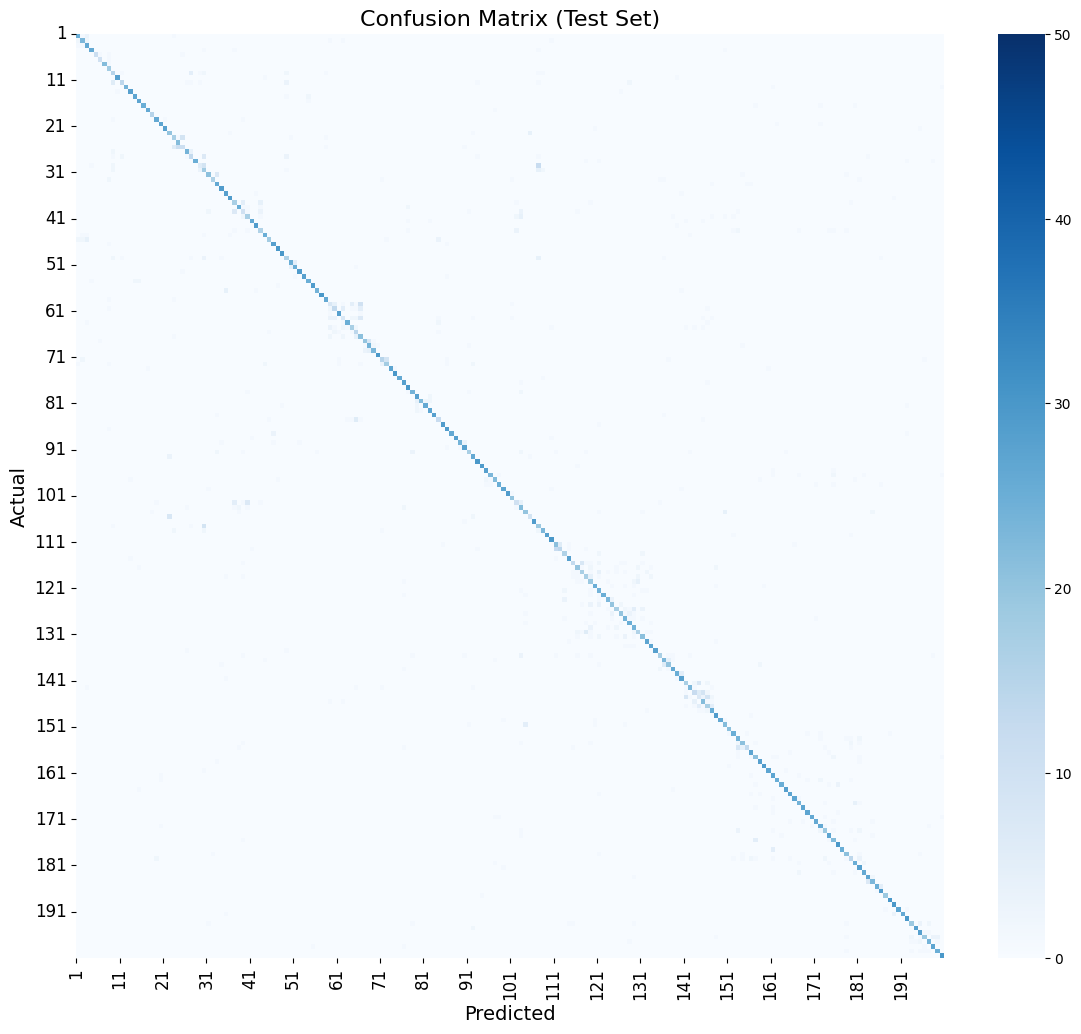

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_preds)

# Plot Confusion Matrix
plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues', vmin=0, vmax=50)

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix (Test Set)', fontsize=16)

# Show every 10th label to avoid clutter
tick_spacing = 10
plt.xticks(np.arange(0, 200, tick_spacing), np.arange(1, 201, tick_spacing), fontsize=12, rotation=90)
plt.yticks(np.arange(0, 200, tick_spacing), np.arange(1, 201, tick_spacing), fontsize=12)

plt.show()


# **Test**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

shutil.unpack_archive("/content/drive/MyDrive/bird_CUB_200_2011.zip", "birds")


<ipython-input-4-4c9c1af69daa>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_bird_identification.pth", map_location=device))

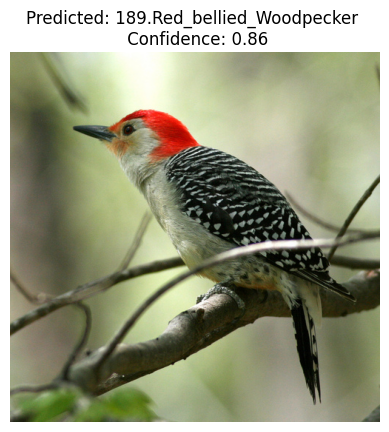

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import os

# Load class names from classes.txt
def load_class_names(dataset_root):
    class_file = os.path.join(dataset_root, "classes.txt")
    class_names = {}
    with open(class_file, "r") as f:
        for line in f:
            class_id, class_name = line.strip().split(" ", 1)
            class_names[int(class_id)] = class_name  # Keep 1-based indexing
    return class_names

dataset_root = "/content/birds/CUB_200_2011"
class_names = load_class_names(dataset_root)  #  Load class names

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b4(weights=None)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.6),
    torch.nn.Linear(model.classifier[1].in_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 200)  # 200 classes
)
model.load_state_dict(torch.load("best_model_bird_identification.pth", map_location=device))
model.to(device)
model.eval()

# Image preprocessing
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and preprocess image
image_path = "/content/Red_Bellied_Woodpecker_0035_181913.jpg"  # Change this
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# Get model prediction
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_class = torch.argmax(probabilities).item() + 1  # Convert to 1-based index

# Get bird species name
predicted_bird = class_names[predicted_class]

# Display the image with prediction
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted: {predicted_bird} \n Confidence: {probabilities[predicted_class - 1]:.2f}")
plt.show()


## **Achievements**

*  Dataset Handling: Loaded and processed the CUB-200-2011 dataset, organizing images, labels, and train-test splits properly. A validation set was also created using stratified sampling to keep class distribution balanced.

*   Model:
Used EfficientNet-B4 as the base model, pre-trained on ImageNet.
Fine-tuned it by freezing 75% of the layers at the start, gradually unfreezing more as training progressed.
Replaced the final classification layer with a custom 512-node fully connected (FC) layer followed by ReLU, dropout, and an output layer for 200 bird classes.

*   Training:
Added label smoothing (0.2) to prevent overconfidence in predictions.
Implemented Mixup augmentation to improve generalization.
Used AdamW optimizer with a learning rate scheduler (ReduceLROnPlateau) for adaptive learning.
Applied gradient clipping (1.0) to stabilize training.

*   Results:
Best validation accuracy: 80.67% (before early stopping at epoch 36).
Final Test Accuracy: 0.7957
Test Precision: 0.8042
Test Recall: 0.7957
Plotted a confusion matrix to analyze class-wise errors.

